<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/gan_colored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, MaxPool2D, Conv2DTranspose, ZeroPadding2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.merge import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from IPython.display import Image

from keras import backend as K


import os
import random
import sys
import datetime
import imageio

import numpy as np

Using TensorFlow backend.


## Downloading Training Set from Gogle Drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!ls /content/gdrive/'My Drive'/neural
!cp /content/gdrive/'My Drive'/neural/ships_256.zip ships_256.zip
!unzip ships_256.zip

03_cifar10_report_ryazhskikh.gdoc  cargo_256.zip  ships_400.zip
boatset.zip			   ships_256.zip
Archive:  ships_256.zip
   creating: ships_256/
  inflating: ships_256/coast_guard_36.jpg  
  inflating: ships_256/coast_guard_22.jpg  
  inflating: ships_256/fishing_val_15.jpg  
  inflating: ships_256/tug_val_9.jpg  
  inflating: ships_256/cargo_102.jpg  
  inflating: ships_256/cargo_116.jpg  
  inflating: ships_256/fishing_val_29.jpg  
  inflating: ships_256/fishing_193.jpg  
  inflating: ships_256/coast_guard_188.jpg  
  inflating: ships_256/ferry_80.jpg  
  inflating: ships_256/fishing_187.jpg  
  inflating: ships_256/ferry_94.jpg  
  inflating: ships_256/cargo_12.jpg  
  inflating: ships_256/fishing_150.jpg  
  inflating: ships_256/ferry_43.jpg  
  inflating: ships_256/tug_64.jpg    
  inflating: ships_256/tug_70.jpg    
  inflating: ships_256/fishing_144.jpg  
  inflating: ships_256/ferry_57.jpg  
  inflating: ships_256/tug_58.jpg    
  inflating: ships_256/coast_guard_177.jpg  
  infl

## Input Files and Reading Operations

In [0]:
K.clear_session()

input_folder = "ships_256"

In [9]:
!rm -rf {input_folder}
!unzip {input_folder}.zip

# !rm -rf __MACOSX
# !rm -rf {input_folder}/.ipynb_checkpoints
# !rm -rf {input_folder}/.DS_Store

Archive:  ships_256.zip
   creating: ships_256/
  inflating: ships_256/coast_guard_36.jpg  
  inflating: ships_256/coast_guard_22.jpg  
  inflating: ships_256/fishing_val_15.jpg  
  inflating: ships_256/tug_val_9.jpg  
  inflating: ships_256/cargo_102.jpg  
  inflating: ships_256/cargo_116.jpg  
  inflating: ships_256/fishing_val_29.jpg  
  inflating: ships_256/fishing_193.jpg  
  inflating: ships_256/coast_guard_188.jpg  
  inflating: ships_256/ferry_80.jpg  
  inflating: ships_256/fishing_187.jpg  
  inflating: ships_256/ferry_94.jpg  
  inflating: ships_256/cargo_12.jpg  
  inflating: ships_256/fishing_150.jpg  
  inflating: ships_256/ferry_43.jpg  
  inflating: ships_256/tug_64.jpg    
  inflating: ships_256/tug_70.jpg    
  inflating: ships_256/fishing_144.jpg  
  inflating: ships_256/ferry_57.jpg  
  inflating: ships_256/tug_58.jpg    
  inflating: ships_256/coast_guard_177.jpg  
  inflating: ships_256/fishing_178.jpg  
  inflating: ships_256/coast_guard_163.jpg  
  inflating: sh

In [21]:
def inputFiles():
    return os.listdir(input_folder)

def read_image(filename):
#     print(filename)
    path = "%s/%s" % (input_folder, filename)
    return imageio.imread(path)

def read_images(files):
    imgs = []
    for f in files:
        im = read_image(f)
#         print(im.shape)
        imgs.append(im)
    return np.array(imgs)


files = inputFiles()
print("Files count: ", len(files))

Files count:  1180


### Sample image

fishing_181.jpg


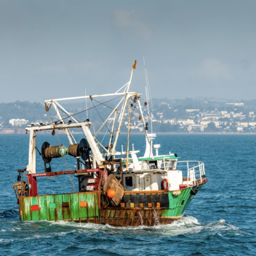

(256, 256, 3)


In [11]:
filename = files[5]
print(filename)
with open("%s/%s" % (input_folder, filename),'rb') as f:
    display(Image(data=f.read(), format='jpg'))
    
content = read_image(filename)
print(content.shape)

## Input Parameters

In [0]:
epochs = 100
latent_dim = 100
batch_size = 6
steps_per_epoch = len(files) // batch_size

img_rows = 256
img_cols = 256
channels = 3

lr = 1e-4
# optimizer = Adam(lr)
optimizer = RMSprop(lr)


## Output Сonfiguration

### Utilities

In [0]:
def optimizer_string():
    if (type(optimizer) == Adam):
        return "adam_%.0E" % lr
    elif (type(optimizer) == RMSprop):
        return "rmsprop_%.0E" % lr
    else:
        return optimizer

def config_string(prefix):
    dt = datetime.datetime.now().strftime('%Y%m%d-%H%M')
    return '%s_%s_latent_%s-batch_%s_%s' % (prefix, optimizer_string(), latent_dim, batch_size, dt)

def folder_to_gif(folder, output_file):
    images = []
    for index in np.arange(0, epochs, sample_interval):
        images.append(imageio.imread("%s/%s.jpg" % (folder, index)))

    imageio.mimsave(output_file, images)
    
def generate_config_name(prefix):
    return "%s_%s_%s" % (prefix, config_string, dt)

### Output Folder

In [35]:
output_folder = config_string("gen")
print(output_folder)
!rm -fr {output_folder}
!mkdir {output_folder}

gen_rmsprop_1E-04_latent_100-batch_6_20190328-1229


# GAN

In [0]:
# del gan
import itertools

class GAN():
    def __init__(self):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()       
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.combined.summary()


    def build_generator(self):
        print("Creating generator")
        
        model = Sequential(name="generator")

        model.add(Dense(self.img_rows * self.img_cols * self.channels, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((self.img_rows // 4, self.img_cols // 4, 16 * self.channels)))
        model.add(UpSampling2D())
        model.add(Conv2D(48, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(96, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        return model
    
    def build_discriminator(self):
        print("Creating discriminator")
        
        model = Sequential(name="discriminator")

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        return model
    
    def train(self, epochs, batch_size=16, sample_interval=50):
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            arr = np.arange(len(files)) 
            np.random.shuffle(arr) 
            rand_files = np.asarray(files)[arr] 
            t = itertools.cycle(rand_files) 
        
            for i in range(steps_per_epoch):
                print('\rEpoch ', end='%s: %s of %s ' % (epoch, i, steps_per_epoch))
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                files_batch = []
                for i in range(batch_size):
                    files_batch.append(next(t))
                imgs = read_images(files_batch)
                imgs = imgs / 127.5 - 1

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    
                # ---------------------
                #  Train Generator
                # ---------------------

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)

#                 print ("%d [D loss: %f] [D acc.: %.2f%%, fake %.2f%%, real %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], 100*d_loss_fake[1], 100*d_loss_real[1], g_loss))

            print("")
            # If at save interval => save generated image samples
            self.sample_images(epoch)


    def sample_images(self, epoch):
        r, c = 1, 1
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
    
        imageio.imwrite("%s/%d.jpg" % (output_folder, epoch), gen_imgs[0])

gan = GAN()
gan.train(epochs=epochs + 1, batch_size=batch_size, sample_interval=sample_interval)



Creating discriminator
Creating generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 100)               0         
_________________________________________________________________
generator (Sequential)       (None, 256, 256, 3)       19922931  
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 71009     
Total params: 19,993,940
Trainable params: 19,922,643
Non-trainable params: 71,297
_________________________________________________________________
Epoch 0: 0 of 196 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0: 195 of 196 


Epoch 1: 195 of 196 


Epoch 2: 195 of 196 


Epoch 3: 195 of 196 


Epoch 4: 195 of 196 


Epoch 5: 195 of 196 


Epoch 6: 195 of 196 


Epoch 7: 195 of 196 


Epoch 8: 195 of 196 


Epoch 9: 195 of 196 


Epoch 10: 195 of 196 


Epoch 11: 195 of 196 


Epoch 12: 195 of 196 


Epoch 13: 195 of 196 


Epoch 14: 195 of 196 


Epoch 15: 195 of 196 


Epoch 16: 195 of 196 


Epoch 17: 195 of 196 


Epoch 18: 195 of 196 


Epoch 19: 195 of 196 


Epoch 20: 195 of 196 


Epoch 21: 195 of 196 


Epoch 22: 195 of 196 


Epoch 23: 195 of 196 


Epoch 24: 195 of 196 


Epoch 25: 195 of 196 


Epoch 26: 195 of 196 


Epoch 27: 195 of 196 


Epoch 28: 195 of 196 


Epoch 29: 195 of 196 


Epoch 30: 195 of 196 


Epoch 31: 195 of 196 


Epoch 32: 195 of 196 


Epoch 33: 195 of 196 


Epoch 34: 195 of 196 


Epoch 35: 195 of 196 


Epoch 36: 195 of 196 


Epoch 37: 195 of 196 


Epoch 38: 195 of 196 


Epoch 39: 195 of 196 


Epoch 40: 195 of 196 


Epoch 41: 195 of 196 


Epoch 42: 195 of 196 


Epoch 43: 195 of 196 


Epoch 44: 195 of 196 


Epoch 45: 195 of 196 


Epoch 46: 195 of 196 


Epoch 47: 195 of 196 


Epoch 48: 195 of 196 


Epoch 49: 195 of 196 


Epoch 50: 195 of 196 


Epoch 51: 195 of 196 


Epoch 52: 195 of 196 


Epoch 53: 195 of 196 


Epoch 54: 195 of 196 


Epoch 55: 195 of 196 


Epoch 56: 195 of 196 


Epoch 57: 195 of 196 


Epoch 58: 195 of 196 


Epoch 59: 195 of 196 


Epoch 60: 195 of 196 


Epoch 61: 195 of 196 


Epoch 62: 195 of 196 


Epoch 63: 195 of 196 


Epoch 64: 195 of 196 


Epoch 65: 195 of 196 


Epoch 66: 195 of 196 


Epoch 67: 195 of 196 


Epoch 68: 49 of 196 

In [0]:
gan.train(epochs=20001, batch_size=batch_size, sample_interval=sample_interval)

## Downloading Output

### Creating GIF

In [0]:
output_file = config_string("train") + ".gif"
folder_to_gif(output_folder, output_file)

### Creating Output Archive

In [0]:
!zip -r {output_folder}.zip {output_folder}